# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

Bibliotecas

* pandas: para ler arquivos as base de dados e trabalhar com os dados
* pathlib: mexer com arquivos e caminhos do computador


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

### Consolidando as base de dados

In [26]:
# Caminho para a pasta onde estão os database
CAMINHO_DATASET = Path('dataset')

# Dicionário com os meses
MESES = {
    'jan': 1,
    'fev': 2,
    'mar': 3,
    'abr': 4,
    'mai': 5,
    'jun': 6,
    'jul': 7,
    'ago': 8,
    'set': 9,
    'out': 10,
    'nov': 11,
    'dez': 12
}

# Lista para acrescentar todos os database
bases_airbnb = []

for arquivo in CAMINHO_DATASET.iterdir():
    base_df = pd.read_csv(CAMINHO_DATASET / arquivo.name, low_memory=False)

    # Pegando o mês a partir do nome do arquivo
    mes = arquivo.name[:3]
    ano = arquivo.name[-8:-4]

    # Criando as colunas 'Mes' e 'Ano' para o database correspondente
    base_df['Mes'] = MESES[mes]
    base_df['Ano'] = int(ano)

    # Acrescentando o DataFrame na lista de database
    bases_airbnb.append(base_df)

# Concatenar todos os DataFrames da Lista
bases_airbnb = pd.concat(bases_airbnb, ignore_index=True)

### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

- Como temos muitas colunas, nosso modelo pode acabar ficando lento.
- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão.
- Colunas a excluir:
    1. Colunas de IDs, URL e informações não relevantes
    2. Colunas repetidas ou muito parecidas (Data x Mês/Ano)
    3. Colunas preenchidas com texto livre, não rodaremos nenhuma análise de palavras ou algo do tipo.
    4. Colunas em que todos ou quase todos os valores são iguais.
    5. Várias colunas de quase mesma informação, no caso localização (Cidade, Bairro, Rua, Estado, CEP), manteremos apenas Lat/Long devido a precisão.
- Para isso, vamos gerar um arquivo em excel com os mil primeiros registros e fazer uma análise qualitativa

In [10]:
# Criando um excel com os primeiros 1000 registros
bases_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

In [ ]:
# verificando conteudos de colunas especificas:
print(bases_airbnb['experiences_offered'].value_counts())
print(bases_airbnb['host_acceptance_rate'].value_counts())

# verificando a quantidade de valores nulos
print(bases_airbnb['square_feet'].isnull().sum())

# comparando conteudo de duas colunas
print((bases_airbnb['host_listings_count'] == bases_airbnb['host_total_listings_count']).value_counts())

Depois da análise qualitativa, levando em conta os critérios utilizados acima, ficamos com as colunas abaixo:

In [27]:
# lista de colunas que manteremos
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','Ano','Mes'
]

# atualizando o dataframe com as colunas
bases_airbnb = bases_airbnb.loc[:, colunas]
display(bases_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,Ano,Mes
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,2018,4
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,2018,4
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
902206,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
902207,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9
902208,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9


### Tratar Valores Faltando

* Mesmo após nossa validação qualitativa, percebemos que muitas dessas colunas apresentam cerca de 50% das linhas, valores NaN.
* Isso pode representar que talvez essas colunas não impactam tanto na nossa análise. Para esses casos temos 3 soluções:
1. Podemos cortar pela metade nossa base de dados pela metade para considerar a outra metade sem ser os valores NaNs (contando que seriam a mesma linha)
2. Preencher com valores 0 mas isso pode enviesar nosso resultado.
3. Excluir as colunas com muitos valores NaN.
* Usaremos a opção 3.

In [28]:
# printar quantos valores NaN temos em cada coluna
print(bases_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [29]:
# removendo colunas onde valores vazios são maiores que 300k
for coluna in bases_airbnb:
    if bases_airbnb[coluna].isnull().sum() > 300_000:
        bases_airbnb = bases_airbnb.drop(coluna, axis=1)
print(bases_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
Ano                            0
Mes                            0
dtype: int64


Para as colunas com poucos valores NaN, optaremos por excluir apenas as linhas em que se encontram esses valores.

In [30]:
# removendo as linhas onde as informações são NaN
bases_airbnb = bases_airbnb.dropna()

In [31]:
# visualiando se ainda temos linhas ou colunas com informações NaN
print(bases_airbnb.isnull().sum())

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
Ano                         0
Mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [32]:
print(bases_airbnb.dtypes)
print('-' * 45) # um espaço entre os comandos
print(bases_airbnb.iloc[0]) # pegar a primeira linha da tabela e comparar com os tipos das colunas

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
Ano                           int64
Mes                           int64
dtype: object
---------------------------------------------
host_is_superhost                                                           f
host_listings_count               

* Temos que verificar se números estão sendo reconhecidos como números, datas como datas e textos como textos, por exemplo.
* Observamos que as colunas "Price" e "Extra_People" estão como objetos e devem ser tratadas como números. Para isso, é necessário remover os caracteres não numéricos (como $ e .) e, sem seguida, alterar o tipo de variável para float.

In [33]:
bases_airbnb['price'] = bases_airbnb['price'].str.replace('$', '', regex=False)
bases_airbnb['price'] = bases_airbnb['price'].str.replace(',', '', regex=False)
bases_airbnb['price'] = bases_airbnb['price'].astype(np.float32, copy=False)

bases_airbnb['extra_people'] = bases_airbnb['extra_people'].str.replace('$', '', regex=False)
bases_airbnb['extra_people'] = bases_airbnb['extra_people'].str.replace(',', '', regex=False)
bases_airbnb['extra_people'] = bases_airbnb['extra_people'].astype(np.float32, copy=False)

In [34]:
print(bases_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
Ano                           int64
Mes                           int64
dtype: object


### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

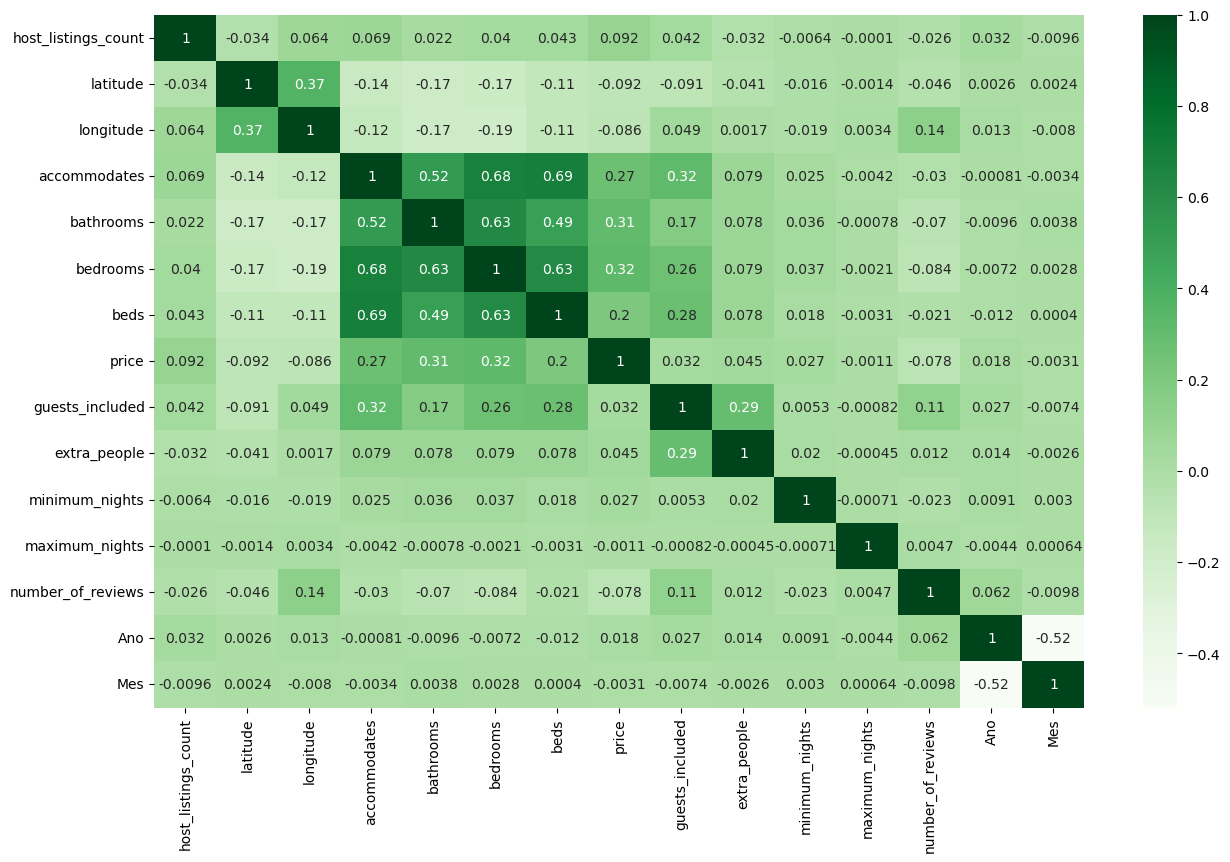

In [35]:
# calculando a correlação entre todas as colunas do nosso dataframe

plt.figure(figsize=(15, 9))
sns.heatmap(bases_airbnb.corr(numeric_only=True), annot=True, cmap='Greens')
plt.show()

- q1: de 0 a 25%
- q3: de 50 a 75%
- amplitude: q3 - q1 
- limite inferior: q1 - 1.5x amplitude
- limite superior: q3 + 1.5x amplitude

In [36]:
def definir_limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    limite_inferior = q1 - 1.5 * amplitude
    limite_superior = q3 + 1.5 * amplitude
    return limite_inferior, limite_superior

- função para criar os graficos de caixa
    - serão dois gráficos, um com eixo automatico e outro com o eixo definido pelos limites inferior e superior

- para visualizar a coluna preços faremos o gráfico de histograma

In [13]:
def diagrama_caixa(coluna):
    # criando uma linha com duas colunas e um sistema de eixo para cada gráfico
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # setando o tamanho das figuras
    fig.set_size_inches(15, 5)

    # exibindo o primeiro gráfico
    sns.boxplot(x=coluna, ax=ax1)

    # setando os limites superior e inferior no eixo do segundo gráfico e exibindo o gráfico
    ax2.set_xlim(definir_limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
    plt.figure(figsize=(15, 10))
    sns.displot(coluna, kind='hist')
    plt.show()

## Analisando a coluna price:

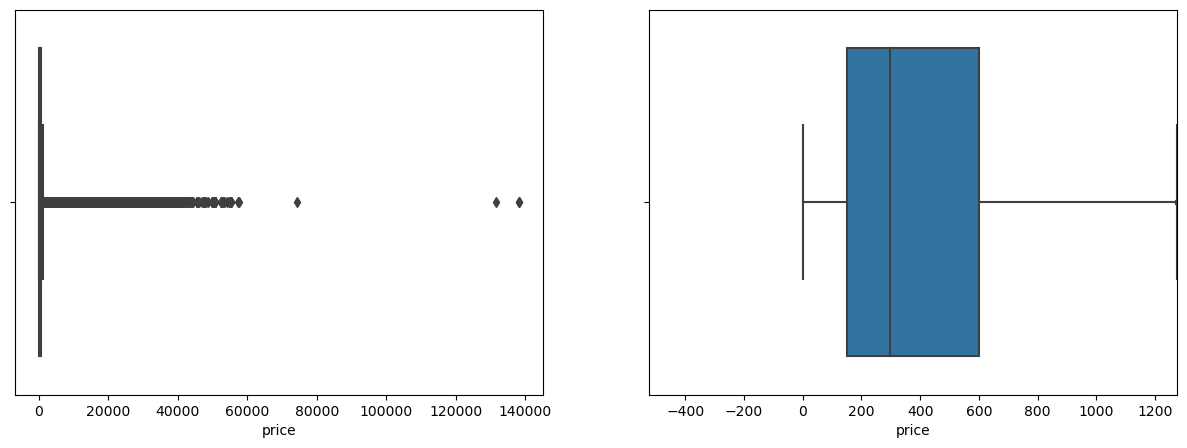

<Figure size 1500x1000 with 0 Axes>

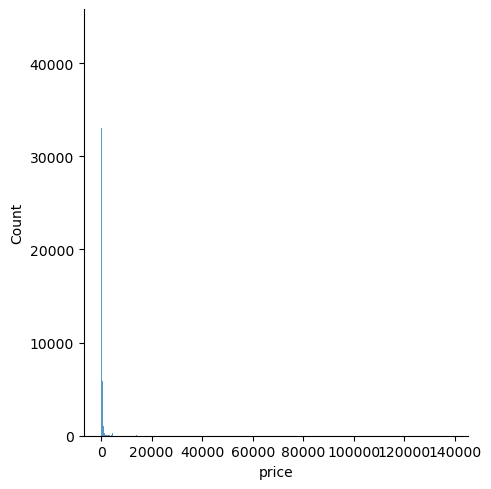

In [15]:
diagrama_caixa(bases_airbnb['price'])
histograma(bases_airbnb['price'])

Como estamos fazendo nosso modelo para casa ou apartamentos acessíveis a maioria das pessoas, estaremos excluindo aqueles valores de imóveis de altíssimo luxo. Por isso, estaremos removendo os "outliers" que são os valores abaixo do limite inferior e acima do limite superior.

In [16]:
def eliminar_outliers(df, coluna):
    qtde_linhas_antes = df.shape[0]
    limite_inferior, limite_superior = definir_limites(df[coluna])
    df = df.loc[(df[coluna] >= limite_inferior) & (df[coluna] <= limite_superior), :]
    linhas_removidas = qtde_linhas_antes - df.shape[0]
    return df, linhas_removidas

In [17]:
bases_airbnb, linhas_removidas = eliminar_outliers(bases_airbnb, 'price')
print(f'{linhas_removidas} linhas removidas.')

87282 linhas removidas.


<Figure size 1500x1000 with 0 Axes>

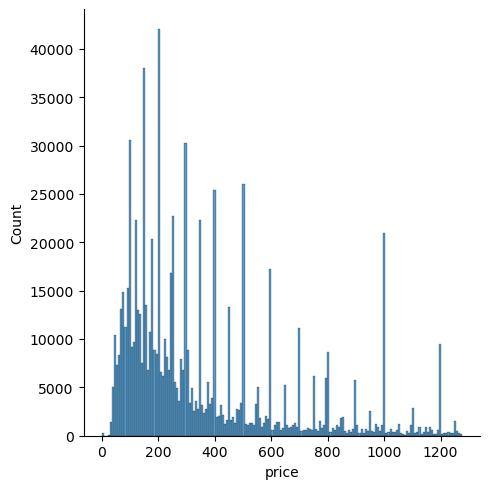

In [18]:
histograma(bases_airbnb['price'])

### extra_people

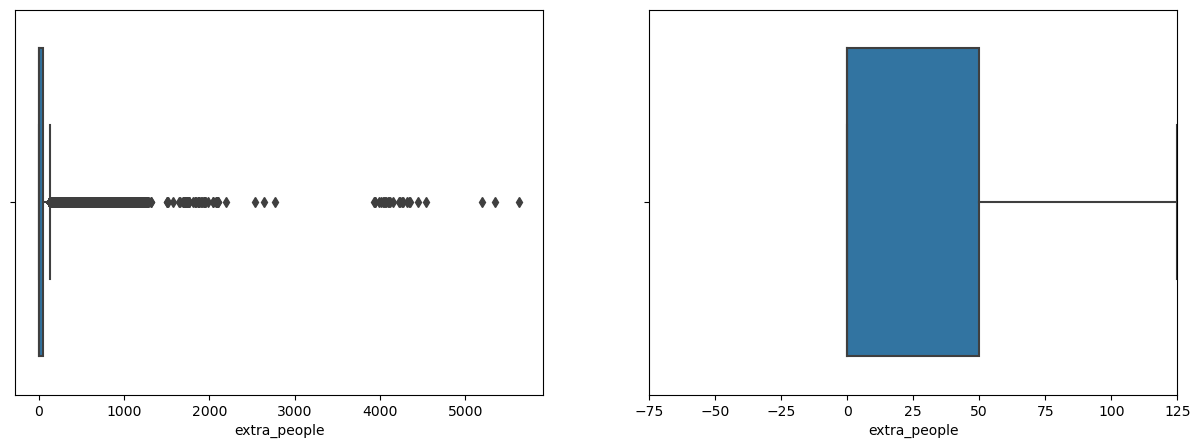

<Figure size 1500x1000 with 0 Axes>

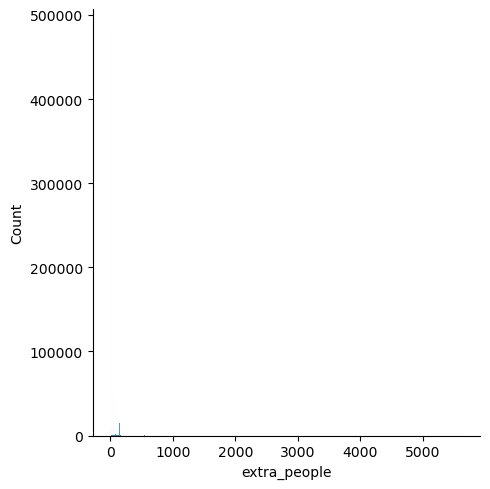

In [19]:
diagrama_caixa(bases_airbnb['extra_people'])
histograma(bases_airbnb['extra_people'])

0 linhas removidas.


<Figure size 1500x1000 with 0 Axes>

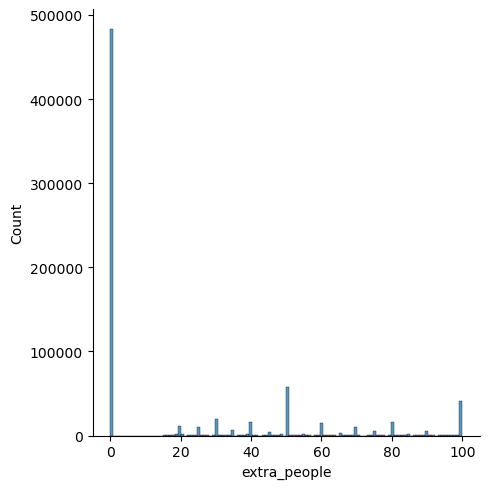

In [24]:
bases_airbnb, linhas_removidas = eliminar_outliers(bases_airbnb, 'extra_people')
print(f'{linhas_removidas} linhas removidas.')
histograma(bases_airbnb['extra_people'])

### Encoding

### Modelo de Previsão

### Análise do Melhor Modelo

### Ajustes e Melhorias no Melhor Modelo